In [1]:
# Khai báo các thư viện cần thiết
from new_import import *

In [2]:
# Khai báo đường dẫn đến kết quả phân loại và kết quả thực tế của địa phương
KD_path = "ThuanHoa/KhoanhDat/ThuanHoa_TKDD2022.shp"
KetQuaPhanLoaiDat = "KetQuaPhanLoaiDat_15-09.tif"

In [3]:
# khai báo các loại đất ứng với các mã đất phân loại được
CODE_MAP = {
    "BHK": 2,
    "CLN": 3,
    "DGD": 6,
    "DGT": 6,
    "DNL": 6,
    "DRA": 6,
    "DSH": 6,
    "DTL": 5,
    "DTS": 6,
    "DYT": 6,
    "LUC": 1,
    "NKH": 3,
    "NTD": 6,
    "NTS": 4,
    "ONT": 6,
    "SKC": 6,
    "SKX": 6,
    "SON": 5,
    "TMD": 6,
    "TON": 6,
    "TSC": 6,
}

label_mapping = {
    "Lua tom": 0,
    "Lua": 1,
    "CHN": 2,
    "CLN": 3,
    "TS": 4,
    "Song": 5,
    "Dat xay dung": 6,
    "Rung": 7
}

# Khai báo các nhãn phân loại đất ứng với 3 loại đất chính
HT_MAP = {
    "NN": {"name": "Đất Nông Nghiệp", "data": [1, 2, 3, 4]},
    "PNN": {"name": "Đất Phi Nông Nghiệp", "data": [6]},
    "TQ": {"name": "Đất Thổ Quả", "data": [15]},
}

In [4]:
print(label_mapping.get(2))

None


In [16]:
def test(KD_path, KetQuaPhanLoaiDat, CODE_MAP, label_mapping):
    gdf = gpd.read_file(KD_path, crs="EPSG:9209")
    polygon = gdf.geometry.values
    label_before = gdf.tenchu.values
    output_image = rioxarray.open_rasterio(KetQuaPhanLoaiDat)
    
    array_list = []
    result = []  
    mapped_array_list = []  

    for i in range(len(polygon)):
        po = polygon[i]
        lb_before = label_before[i]  
        code_lb = CODE_MAP.get(lb_before, 15)
        
        if ";" in lb_before:
            lb_before = "TQ"
        
        try:
            qr = output_image.rio.clip([po], "EPSG:9209")
            changed_points = qr.where(qr != float(code_lb), np.nan)  

            # Kiểm tra có điểm nào thay đổi không
            if changed_points.notnull().any():  
                label_after_values = qr.where(changed_points.notnull()).values.flatten()

                for value in label_after_values:
                    if not np.isnan(value):
                        label_after_key = [key for key, val in label_mapping.items() if val == int(value)]
                        label_after_key = label_after_key[0] if label_after_key else None

                        result.append({
                            'label_before': lb_before,  
                            'label_after': label_after_key  
                        })
                        
                        mapped_array_list.append({
                            'image': changed_points,
                            'label_before': lb_before,
                            'label_after': label_after_key
                        })
                
            array_list.append(changed_points)
        except Exception as e:
            pass

    return array_list, result, mapped_array_list


In [17]:
# Tiến hành chồng lắp
array_list, result, mapped_array_list = test(KD_path, KetQuaPhanLoaiDat, CODE_MAP, label_mapping)

In [ ]:
array_list

In [18]:
df = pd.DataFrame(result)
grouped_counts = df.groupby(['label_before', 'label_after']).size().reset_index(name='count')
total_count = len(df)


grouped_counts['percentage'] = grouped_counts['count'] / total_count

grouped_counts

,label_before,label_after,count,percentage
0,BHK,CLN,1833,0.036410
1,BHK,Dat xay dung,70,0.001390
2,BHK,Lua,1344,0.026696
3,BHK,Rung,526,0.010448
4,BHK,TS,1,0.000020
5,CLN,CHN,515,0.010230
6,CLN,Dat xay dung,360,0.007151
7,CLN,Lua,847,0.016824
8,CLN,Rung,776,0.015414
9,DGD,CHN,11,0.000218


In [20]:
sankey_data = [['From', 'To', 'Weight']] + [
    [row['label_before'], row['label_after'], row['count']]
    for _, row in grouped_counts.iterrows()
]

sankey_data

[['From', 'To', 'Weight'],
 ['BHK', 'CLN', 1833],
 ['BHK', 'Dat xay dung', 70],
 ['BHK', 'Lua', 1344],
 ['BHK', 'Rung', 526],
 ['BHK', 'TS', 1],
 ['CLN', 'CHN', 515],
 ['CLN', 'Dat xay dung', 360],
 ['CLN', 'Lua', 847],
 ['CLN', 'Rung', 776],
 ['DGD', 'CHN', 11],
 ['DGD', 'CLN', 14],
 ['DGD', 'Lua', 53],
 ['DGD', 'Rung', 4],
 ['DGT', 'CHN', 1273],
 ['DGT', 'CLN', 2492],
 ['DGT', 'Lua', 2544],
 ['DGT', 'Rung', 538],
 ['DGT', 'TS', 11],
 ['DNL', 'CHN', 5],
 ['DNL', 'CLN', 5],
 ['DNL', 'Rung', 4],
 ['DRA', 'CHN', 11],
 ['DRA', 'CLN', 108],
 ['DRA', 'Lua', 26],
 ['DRA', 'Rung', 10],
 ['DSH', 'CLN', 4],
 ['DTL', 'CHN', 1038],
 ['DTL', 'CLN', 2736],
 ['DTL', 'Dat xay dung', 255],
 ['DTL', 'Lua', 2482],
 ['DTL', 'Rung', 401],
 ['DTS', 'CHN', 34],
 ['DTS', 'CLN', 77],
 ['DTS', 'Rung', 37],
 ['DYT', 'CHN', 3],
 ['DYT', 'CLN', 15],
 ['DYT', 'Lua', 2],
 ['LUC', 'CHN', 1586],
 ['LUC', 'CLN', 4359],
 ['LUC', 'Dat xay dung', 188],
 ['LUC', 'Lua tom', 2],
 ['LUC', 'Rung', 727],
 ['LUC', 'TS', 34],
 [

In [ ]:
mapped_array_list

In [10]:
rs = merge_arrays(array_list, nodata = np.nan)

In [11]:
rs

<xarray.DataArray (band: 1, y: 484, x: 791)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 5.952e+05 5.952e+05 ... 6.031e+05 6.031e+05
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan

In [12]:
save_path = "ThuanHoa/KetQuaMoi"

In [13]:
if not os.path.exists(save_path):
        os.mkdir(save_path)
rs.rio.to_raster(f"{save_path}/ChongLap_test.tif")
print(f"save {save_path}/ChongLap_test.tif")

save ThuanHoa/KetQuaMoi/ChongLap_test.tif


In [14]:
# cấu hình màu cho các loại đất
colors = [
    "#abcee9",
    "#ffef44",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]

/tmp/ipykernel_174/1556837544.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


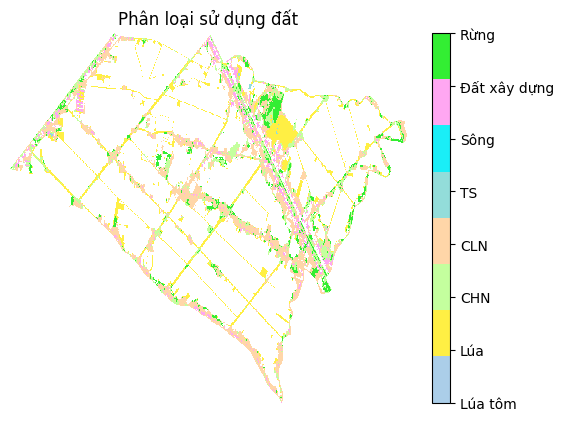

In [15]:
# hiển thị phân loại sử dụng đất
cmap = ListedColormap(colors)
img = rs.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()